In [1]:
# coding: utf-8
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold

In [2]:
train=pd.read_csv("data/train_data.csv")
test=pd.read_csv("data/test_a.csv")

In [3]:
# train=train[train["tradeMoney"]<25000]
# train=train[train["area"]<200]
# train=train[train["area"]>12]

In [4]:
# traiin=train[(train["tradeMoney"]<18000)&(train["tradeMoney"]>100) ]

# train=train[train["area"]<200]
# train=train[train["area"]>10]

# train = train [train['totalFloor'] <80]
# train = train [train['tradeMeanPrice'] <100000]
# train = train [train['remainNewNum'] <4000]

In [5]:
test['tradeMoney']=-1
data=pd.concat([train,test])

In [6]:
for col in data.columns:
    if data[col].dtype=="object":
        print(col)

rentType
houseType
houseFloor
houseToward
houseDecoration
communityName
city
region
plate
buildYear
tradeTime


In [7]:
def get_local(df):
    return df['region']+"_"+df['plate']+"_"+df['communityName']
data['local']=data.apply(lambda x:get_local(x),1)

In [8]:
data['houseToward']=data['houseToward'].apply(lambda x:x.replace("暂无数据","南"),1)

In [9]:
import time
def datetime_timestamp(dt):
    s = time.mktime(time.strptime(dt,'%Y/%m/%d'))
    return s
def get_feat(data):
    data['pv']=data['pv'].fillna(data['pv'].mean())
    data['uv']=data['uv'].fillna(data['uv'].mean())
    data['rentType']=data['rentType'].map({"整租":1,"合租":2})
    data['room_num']=data['houseType'].apply(lambda x:int(x[0]),1)
    data['hall_num']=data['houseType'].apply(lambda x:int(x[2]),1)
    data['toilet_num']=data['houseType'].apply(lambda x:int(x[4]),1)
    data['total_num']=data['room_num']+data['toilet_num']+data['hall_num']
    data['houseFloor']=data['houseFloor'].map({"低":0,"中":1,"高":2})
    data['houseDecoration']=data['houseDecoration'].map({"其他":0,"毛坯":1,"简装":2,"精装":3})
    data['communityName_freq']=data['communityName'].map(data['communityName'].value_counts().rank()/len(data['communityName'].unique()))
    data['region']=data['region'].map(data['region'].value_counts().rank()/len(data['region'].unique()))
    data['plate']=data['plate'].map(data['plate'].value_counts().rank()/len(data['plate'].unique()))
    data['local']=data['local'].map(data['local'].value_counts().rank()/len(data['local'].unique()))
#     data['houseType']=data['houseType'].map(data['houseType'].value_counts().rank()/len(data['houseType'].unique()))
    data['buildYear']=data['buildYear'].apply(lambda x:x.replace("暂无信息","1970"),1)
    data['buildYear']=data['buildYear'].astype(int)
    data['year']=data['tradeTime'].apply(lambda x:int(x.split("/")[0]),1)
    data['month']=data['tradeTime'].apply(lambda x:int(x.split("/")[1]),1)
    data['day']=data['tradeTime'].apply(lambda x:int(x.split("/")[2]),1)
#     data['build_time']=data['year']-data['buildYear']
    data['tradeTime']=data['tradeTime'].apply(lambda x:datetime_timestamp(x),1)
    for col in ['houseType',"houseToward","communityName",]:
        lbl =LabelEncoder()
        data[col]=lbl.fit_transform(data[col])
    return data

In [10]:
data=get_feat(data)

In [11]:
data['room_all'] = data['room_num'] + data['hall_num'] +data['toilet_num'] 
    
data['per_room'] = data['area'] / data['room_all']

In [12]:
# data['avg_money']=data['tradeMoney']/data['area']

In [13]:
train=data[data.tradeMoney!=-1]
test=data[data.tradeMoney==-1]

In [14]:
train['per_area'] =  train['tradeMoney']/train['area']
train=train[(train["per_area"]<1000)&(train["per_area"]>25) ]

train=train[(train["tradeMoney"]<18000)&(train["tradeMoney"]>100) ]

train=train[train["area"]<200]
train=train[train["area"]>10]

train = train [train['totalFloor'] <80]
train = train [train['tradeMeanPrice'] <100000]
train = train [train['remainNewNum'] <4000]

C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


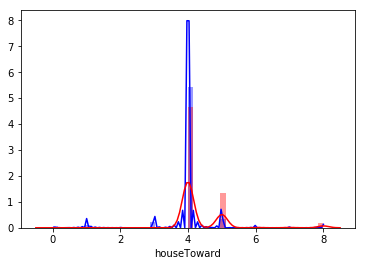

In [15]:
import seaborn as sns
get_ipython().magic('matplotlib inline')
sns.distplot(train['houseToward'].fillna(0),color="blue")
sns.distplot(test['houseToward'].fillna(0),color="red")

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
from itertools import product
from scipy import stats
from scipy.stats import skew, kurtosis
def get_mode(row):
    return stats.mode(row)[0][0]  
def get_unique_num(row):
    if len(row) == 0:
        return 0
    return len(np.unique(row))
def get_len(row):
    return len(row)
def get_unique_freq(row):
    if len(row) == 0:
        return 0
    return float(len(np.unique(row))) / len(row)
def get_max(row):
    return np.max(row)
def get_min(row):
    return np.min(row)
def get_mean(row):
    return np.mean(row)
def get_std(row):
    return np.std(row)
def get_skew(row):
    return skew(row)
class MeanEncoder:
    def __init__(self, categorical_features,stats="mean", flag="mean",n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode
        :param n_splits: the number of splits used in mean encoding
        :param target_type: str, 'regression' or 'classification'
        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        '''
        >>>example:
        mean_encoder = MeanEncoder(
                        categorical_features=['regionidcity',
                          'regionidneighborhood', 'regionidzip'],
                target_type='regression'
                )

        X = mean_encoder.fit_transform(X, pd.Series(y))
        X_test = mean_encoder.transform(X_test)


        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}
        self.stats=stats
        self.flag=flag
        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func,stats,flag):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()
       
        if target is not None:
            nf_name = '{}_pred_{}_{}'.format(variable, target,stats)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred_{}'.format(variable,stats)
            X_train['pred_temp'] = y_train  # regression
#         prior = X_train['pred_temp'].mean()
        stats_dict={"mean":get_mean,
                    "min":get_min,
                    "max":get_max,
                    "std":get_std,
                    "skew":get_skew,
                    "mode":get_mode,
                    "kurt":kurtosis,
                    "unique":get_unique_num,
                    "freq":get_unique_freq
                   
                   } 
        if stats=="mode":
            col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({stats: get_mode, 'beta': 'size'})
        if stats=="kurt":
            col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({stats: kurtosis, 'beta': 'size'})
        if stats=="unique":
            prior = get_unique_num(X_train['pred_temp'])
            col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({stats: get_unique_num, 'beta': 'size'})
        if stats=="freq":
            prior = get_unique_freq(X_train['pred_temp'])
            col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({stats: get_unique_freq, 'beta': 'size'})
        
        if stats in ["mean","max","min","sum","std","var","median","skew"]: 
            col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({stats: stats, 'beta': 'size'})
            
        if flag=="mean":
            prior = stats_dict['mean'](X_train['pred_temp'])
        elif flag=="median":
            prior = X_train['pred_temp'].median()
        else:
            prior = stats_dict[stats](X_train['pred_temp'])
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y[stats]
        col_avg_y.drop(['beta', stats], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        stats=self.stats
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}_{}'.format(variable, target,stats): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}_{}'.format(variable, target,stats)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func,self.stats,self.flag)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred_{}'.format(variable,stats): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred_{}'.format(variable,stats)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func,self.stats,self.flag)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        stats=self.stats
        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}_{}'.format(variable, target,stats)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred_{}'.format(variable,stats)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [17]:
len(train)

36910

In [18]:
# traiin=train[(train["tradeMoney"]<18000)&(train["tradeMoney"]>100) ]

# train=train[train["area"]<200]
# train=train[train["area"]>10]

# train = train [train['totalFloor'] <80]
# train = train [train['tradeMeanPrice'] <100000]
# train = train [train['remainNewNum'] <4000]

In [19]:
# train=train[train["tradeMoney"]<15000]
# train=train[train["area"]<200]
# train=train[train["area"]>12]

In [20]:
train.index=range(len(train))
test.index=range(len(test))

In [21]:
flag="mean"
print("mean...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("std...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="std",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)

print("max...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="max",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("min...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="min",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("skew...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="skew",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("kurt...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="kurt",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("unique...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="unique",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)
print("freq...")
mean_encoder = MeanEncoder(
                        categorical_features=['communityName',"plate","buildYear","totalFloor","day"],
                stats="freq",
                target_type='regression',flag=flag
                )

train = mean_encoder.fit_transform(train, pd.Series(train['tradeMoney']))
test = mean_encoder.transform(test)

mean...


C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:108: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


std...
max...
min...
skew...
kurt...


C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:99: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


unique...


C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


freq...


C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:105: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [22]:
def add(x, y):
    return x + y


def substract(x, y):
    return x - y


def times(x, y):
    return x * y


def divide(x, y):
    return (x + 0.001)/(y + 0.001)


CrossMethod = {
#                     '+':add,
#                    '-':substract,
    '*': times,
    '/': divide, }


def get_cv_feat(cv_col, train):
    bh = pd.DataFrame()

    for i in range(len(cv_col)):
        for j in range(i+1, len(cv_col)):
            for k in CrossMethod:
                bh[cv_col[i]+k+cv_col[j]
                   ] = CrossMethod[k](train[cv_col[i]], train[cv_col[j]])
#                 print(cv_col[i]+k+cv_col[j],"done")
    return bh

In [23]:
# cv_train=get_cv_feat(f15,train)
# cv_test=get_cv_feat(f15,test)

In [24]:
train=train#.join(cv_train)
test=test#.join(cv_train)

In [25]:
data=pd.concat([train,test])
groupby_feat=data.groupby("communityName",as_index=False)['area'].agg({"area_mean":"mean","area_std":"std","area_skew":"skew",
                                                         "area_min":"min","area_max":"max",})

groupby_feat1=data.groupby("communityName",as_index=False)['day'].agg({"day_mean":"mean","day_std":"std","day_skew":"skew",
                                                         "day_min":"min","day_max":"max",})

groupby_feat2=data.groupby("communityName",as_index=False)['month'].agg({"month_mean":"mean","month_std":"std","month_skew":"skew",
                                                         "month_min":"min","month_max":"max"})

C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
train=pd.merge(train,groupby_feat,on="communityName",how="left")
test=pd.merge(test,groupby_feat,on="communityName",how="left")

train=pd.merge(train,groupby_feat1,on="communityName",how="left")
test=pd.merge(test,groupby_feat1,on="communityName",how="left")

train=pd.merge(train,groupby_feat2,on="communityName",how="left")
test=pd.merge(test,groupby_feat2,on="communityName",how="left")

In [27]:
# train['area-mean']=train['area']-train['area_mean']
# train['area-mode']=train['area']-train['area_mode']
# train['area-mean/std']=train['area-mean']/train['area_std']
# train['area-mode/std']=train['area-mode']/train['area_std']
# train['area-mean/max-min']=train['area-mean']/(train['area_max']-train['area_min'])

# test['area-mean']=test['area']-test['area_mean']
# test['area-mode']=test['area']-test['area_mode']
# test['area-mean/std']=test['area-mean']/test['area_std']
# test['area-mode/std']=test['area-mode']/test['area_std']
# test['area-mean/max-min']=test['area-mean']/(test['area_max']-test['area_min'])

In [28]:
features = [x for x in train.columns if x not in ["per_area","avg_money","communityName",'ID',"year","city","tradeMoney",'tradeTime','total_num']]
label = "tradeMoney"
# label = "avg_money"

In [29]:
len(features)

110

In [30]:
def r2(y_pred,train_data):
    y_true=train_data.get_label()
    return "r2",r2_score(y_true,y_pred),True

In [31]:
import lightgbm as lgb
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model'):
    folds=5
    
    kf = KFold(n_splits=folds, random_state=1017, shuffle=True)
    fold_splits = kf.split(train, target)
    
    cv_scores = []
    pred_full_test = 0
    
    pred_train = np.zeros((train.shape[0], folds))
    feature_importance_df = pd.DataFrame()
    i = 1
    for dev_index, val_index in fold_splits:
        print( label + ' | FOLD ' + str(i) + '/'+str(folds))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
#         temp=pd.DataFrame(index=range(len(val_y)))
#         temp['y_true']=val_y.values
#         temp['area']=val_X['area'].values
#         temp['y_true']=temp['y_true']*temp['area']
#         temp['y_pred']=pred_val_y
#         temp['y_pred']=temp['y_pred']*temp['area']
      
        if eval_fn is not None:
#             cv_score = eval_fn(temp['y_true'], temp['y_pred'])
            cv_score = eval_fn(val_y,pred_val_y)
            
            cv_scores.append(cv_score)
          
           
            print(label + ' cv score {}: LOSS {} '.format(i, cv_score))
            
            
            print("##"*40)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] =train.columns.values
        fold_importance_df['importance'] =importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
        i += 1
       

    print('{} cv mean LOSS score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std LOSS score : {}'.format(label, np.std(cv_scores)))
   

    
    pred_full_test = pred_full_test / float(folds)
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores, 
               'importance': feature_importance_df,
               }
    return results

params = {
        'bagging_freq': 1,
     "bagging_seed": 23,
        'bagging_fraction': 0.85,
        'boost': 'gbdt',
        'feature_fraction': 0.4,
        'learning_rate': 0.01,
        'max_depth': -1,
#     "lambda_l1": 0.2,
#         'metric': 'l2',
#         'min_data_in_leaf': 20,
#     'min_child_samples':20,
      "metric": 'rmse',
        'num_leaves': 15,
        'num_threads': -1,
        
        'objective': 'regression_l2',
        'verbosity': -1,
     'verbose_eval': 200,
          "random_state":1017,
          'num_rounds': 50000,
     'early_stop': 200,
    }

def runLGB(train_X, train_y, test_X, test_y, test_X2, params):
#     print('Prep LGB')
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(test_X, label=test_y)
    watchlist = [d_train, d_valid]
#     print('Train LGB')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      feval=r2,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    print('Predict 1/2')
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
   
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    
    return pred_test_y.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model.feature_importance()
 
results = run_cv_model(train[features], test[features], train[label], runLGB, params, r2_score, 'LGB')

LGB | FOLD 1/5
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 1013.8	training's r2: 0.843417	valid_1's rmse: 1059.13	valid_1's r2: 0.83704
[400]	training's rmse: 817.352	training's r2: 0.898222	valid_1's rmse: 880.832	valid_1's r2: 0.887288
[600]	training's rmse: 757.65	training's r2: 0.912547	valid_1's rmse: 838.193	valid_1's r2: 0.897937
[800]	training's rmse: 722.683	training's r2: 0.920433	valid_1's rmse: 816.537	valid_1's r2: 0.903142
[1000]	training's rmse: 697.491	training's r2: 0.925884	valid_1's rmse: 802.15	valid_1's r2: 0.906525
[1200]	training's rmse: 677.576	training's r2: 0.930056	valid_1's rmse: 792.306	valid_1's r2: 0.908805
[1400]	training's rmse: 661.312	training's r2: 0.933373	valid_1's rmse: 784.917	valid_1's r2: 0.910499
[1600]	training's rmse: 647.247	training's r2: 0.936177	valid_1's rmse: 779.197	valid_1's r2: 0.911798
[1800]	training's rmse: 635.169	training's r2: 0.938537	valid_1's rmse: 774.657	valid_1's r2: 0.912823
[20

[8400]	training's rmse: 460.986	training's r2: 0.967966	valid_1's rmse: 697.404	valid_1's r2: 0.926317
[8600]	training's rmse: 457.718	training's r2: 0.968419	valid_1's rmse: 697.187	valid_1's r2: 0.926362
[8800]	training's rmse: 454.542	training's r2: 0.968856	valid_1's rmse: 697.021	valid_1's r2: 0.926397
[9000]	training's rmse: 451.352	training's r2: 0.969291	valid_1's rmse: 696.683	valid_1's r2: 0.926469
[9200]	training's rmse: 448.245	training's r2: 0.969712	valid_1's rmse: 696.519	valid_1's r2: 0.926503
[9400]	training's rmse: 445.287	training's r2: 0.970111	valid_1's rmse: 696.22	valid_1's r2: 0.926567
[9600]	training's rmse: 442.306	training's r2: 0.97051	valid_1's rmse: 696.084	valid_1's r2: 0.926595
[9800]	training's rmse: 439.315	training's r2: 0.970907	valid_1's rmse: 695.925	valid_1's r2: 0.926629
[10000]	training's rmse: 436.415	training's r2: 0.97129	valid_1's rmse: 695.845	valid_1's r2: 0.926646
[10200]	training's rmse: 433.628	training's r2: 0.971656	valid_1's rmse: 69

Predict 1/2
LGB cv score 3: LOSS 0.9280818695180625 
################################################################################
LGB | FOLD 4/5
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 1021.98	training's r2: 0.84369	valid_1's rmse: 1009.71	valid_1's r2: 0.840943
[400]	training's rmse: 828.349	training's r2: 0.897311	valid_1's rmse: 832.178	valid_1's r2: 0.891958
[600]	training's rmse: 767.961	training's r2: 0.911738	valid_1's rmse: 781.899	valid_1's r2: 0.904619
[800]	training's rmse: 731.956	training's r2: 0.91982	valid_1's rmse: 757.784	valid_1's r2: 0.910412
[1000]	training's rmse: 706.332	training's r2: 0.925335	valid_1's rmse: 743.392	valid_1's r2: 0.913782
[1200]	training's rmse: 686.083	training's r2: 0.929555	valid_1's rmse: 733.381	valid_1's r2: 0.916089
[1400]	training's rmse: 669.62	training's r2: 0.932895	valid_1's rmse: 726.908	valid_1's r2: 0.917564
[1600]	training's rmse: 655.382	training's r2: 0.935718	valid_1's rmse: 72

[4600]	training's rmse: 538.601	training's r2: 0.956484	valid_1's rmse: 705.669	valid_1's r2: 0.923076
[4800]	training's rmse: 533.628	training's r2: 0.957284	valid_1's rmse: 704.875	valid_1's r2: 0.923249
[5000]	training's rmse: 528.627	training's r2: 0.958081	valid_1's rmse: 703.98	valid_1's r2: 0.923444
[5200]	training's rmse: 523.85	training's r2: 0.958835	valid_1's rmse: 703.526	valid_1's r2: 0.923543
[5400]	training's rmse: 519.297	training's r2: 0.959547	valid_1's rmse: 702.889	valid_1's r2: 0.923681
[5600]	training's rmse: 514.74	training's r2: 0.960254	valid_1's rmse: 702.493	valid_1's r2: 0.923767
[5800]	training's rmse: 510.403	training's r2: 0.960921	valid_1's rmse: 701.976	valid_1's r2: 0.923879
[6000]	training's rmse: 506.098	training's r2: 0.961577	valid_1's rmse: 701.61	valid_1's r2: 0.923959
[6200]	training's rmse: 501.888	training's r2: 0.962214	valid_1's rmse: 701.179	valid_1's r2: 0.924052
[6400]	training's rmse: 497.774	training's r2: 0.962831	valid_1's rmse: 700.6

In [32]:
imports = results['importance'].groupby('feature')['feature', 'importance'].mean().reset_index()
imp=imports.sort_values('importance', ascending=False)
imp.index=range(len(imp))
imp.iloc[:310]

,feature,importance
0,area,6204.2
1,per_room,4824.6
2,communityName_pred_mean,3687.8
3,area_mean,3188.8
4,communityName_pred_max,3014.4
5,communityName_pred_min,2741.0
6,houseType,2593.0
7,day_pred_freq,2528.4
8,area_skew,2464.0
9,day_pred_std,2457.8


In [33]:
features=imp.feature.values[:300]

In [34]:
f15=imp.feature.values[:15]

In [35]:
train_predictions = [r[0] for r in results['train']]
test_predictions = [r[0] for r in results['test']]

In [36]:
sub=test[['ID']]
sub[label]=test_predictions

C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
# sub[label]=sub[label]*test['area']

In [38]:
sub[[label]].to_csv("submit.csv",index=False,header=None)